In [1]:
# Setup paths and imports
import os
import sys
from pathlib import Path

ROOT = str(Path().resolve().parents[1])
sys.path.append(ROOT)
os.chdir(ROOT)

# For numerics
import numpy as np

# For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# For colorblind plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

# For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import from lepton_nucleus_collisions module
from thesis_code.lepton_nucleus_collisions.experiments import E137, EIC, MuBeD, MuSIC, FinalState

# Comparing Lepton-Nucleus Collision Experiments

In this notebook, we compare the production cross-sections for the process $\ell^- A_Z \rightarrow \ell'^- A_Z \varphi$, where $\varphi$ is a scalar or vector with potentially PV and LFV couplings. We also compare the "exact" cross-section (assuming the $A_Z$ is a spin-0 source of charge $Z$ for simplicity) to the approximate cross-section obtained via the Weizacker-Williams (WW) and *Improved* Weizacker-Williams approximation.

NOTE: To run this notebook, you must first run ````Cache Differential Cross Sections.ipynb````.

In [2]:
# Some set-up for plots involving the lepton-nucleus collider experiments
experiments = [E137, EIC, MuBeD, MuSIC]
experiment_TeX = [f'${{\\rm {experiment}}}$' for experiment in experiments]
TeX_dict = dict(zip(experiments, experiment_TeX))
experiment_colors = [colors[1], colors[0], colors[3], colors[2]]
color_dict = dict(zip(experiments, experiment_colors))

## Cross-sections plots

Here, we define a helper function for plotting the cross-section given a set of parameters (method, t_cut_off, lepton, boson_type).

In [3]:
def plot_crossx(masses, experiment, params, PV_angle = None, ax = None, units = 'pb', label = None, fill_alpha = 0.2, **plot_kwargs):    
    if not ax:
        ax = plt.gca()

    # By default, use the color for the experiment set at the start
    plot_kwargs['color'] = plot_kwargs.get('color',color_dict[experiment])        

    # Compute cross-section for each of the provided masses
    final_states = np.array([FinalState(*params, m) for m in masses])
    crossx = np.array([experiment.cross_section(final_state, units = units, interpolate_mass = True) for final_state in final_states])

    # If PV_angle is None, fill between \sigma_{0} and \sigma_{0} + \sigma_{PV}
    if PV_angle is None:
        fill_kwargs = plot_kwargs.copy()
        fill_kwargs['alpha'] = fill_alpha
        ax.fill_between(masses,
                        crossx[:,0], #\sigma_{0}
                        crossx.sum(axis = 1), #\sigma_{0} + \sigma_{PV}
                        alpha = fill_alpha,
                        **plot_kwargs)
        
        ax.plot(masses,
                crossx[:, 0], #\sigma_{0}
                label = label,
                **plot_kwargs)

        # Threshold beyond which we plot the PV cross-section
        # (This is to prevent two dashed lines overlapping out
        # of sync).
        plot_PV = np.abs((crossx[:, 1])/crossx[:, 0]) > 0.05

        ax.plot(masses[plot_PV],
                crossx.sum(axis = 1)[plot_PV], #\sigma_{PV}
                **plot_kwargs)
    else:
        ax.plot(masses, 
                crossx[:,0]+np.sin(PV_angle)**2 * crossx[:, 1],
                **plot_kwargs)

###  Plotting the cross-sections at each experiment:

To plot the cross-sections at each experiment, we first define a function ````plot_each_lepton```` to plot the cross-section for each final-state lepton given a final-state particle type. Then, we define a function ````compare_particle_types```` which sets these lepton plots side-by-side for a (pseudo-)scalar and (axial-)vector at a given experiment. For a given $t_{\rm cutoff}$ (default is $1.0~{\rm GeV}^2$) and method (default is exact), this figure allows comparison of the total production cross-section of the particle $\varphi$ at each experiment. 

In [4]:
def plot_each_lepton(experiment, boson_type, method = 'exact', t_cut_off = 1.0, masses = None, PV_angle = None, ax = None, units = 'pb', **plot_kwargs):
    if not ax:
        ax = plt.gca()

    # If masses aren't given, use the masses that 
    # are cached for the final-state in question.
    use_cached_masses = masses is None

    # Plot the cross-section for each lepton, 
    linestyles = ['solid', 'dashed', 'dotted']
    leptons = ['e', 'mu', 'tau']
    for idx, (linestyle, lepton) in enumerate(zip(linestyles, leptons)):
        if use_cached_masses:
            masses = experiment.cached_masses(method, t_cut_off, lepton, boson_type)

        plot_kwargs['linestyle'] = linestyle
        plot_crossx(masses, 
                    experiment,
                    (method, t_cut_off, lepton, boson_type),
                    PV_angle = PV_angle,
                    ax = ax,
                    units = units,
                    fill_alpha = 0.2,
                    **plot_kwargs)

def compare_particle_types(experiments,
                           ax1,
                           ax2,
                           t_cut_off = 1.0,
                           method = 'exact',
                           masses = None,
                           units = 'pb',
                           ylim = (1e0,1e14),
                           xlim = (1e-3,2e2)):

    # LEFT PLOT: (pseudo)-scalar
    
    params = {'boson_type': 'scalar',
              't_cut_off': t_cut_off,
              'method': method}
    
    for experiment in experiments:
        plot_each_lepton(experiment, masses = masses, ax = ax1, **params)
        # Make legend handle/label
        ax1.plot([1e16],
                 color = color_dict[experiment],
                 linestyle = 'solid',
                 label = TeX_dict[experiment])

    # Title
    ax1.set_title("$\\textrm{(Pseudo-)Scalar}$")

    # Format tick parameters
    ax1.tick_params(which = 'both', direction = 'in')

    # Label y-axis only for left-plot
    li = experiment.lepton
    li = li if li == 'e' else f'\\{li}'
    ax1.set_ylabel(f'$\\sigma({li}^- A_Z \\rightarrow \\ell^- A_Z \\varphi)/g_{{{li}\\ell}}^2~[{{\\rm {units}}}]$')

    # RIGHT PLOT: (axial)-vector
    
    params = {'boson_type': 'vector',
              't_cut_off': t_cut_off,
              'method': method}
    
    for experiment in experiments:
        plot_each_lepton(experiment, masses = masses, ax = ax2, **params)
        # Make legend handle/label
        ax2.plot([1e16],
                 color = color_dict[experiment],
                 linestyle = 'solid',
                 label = TeX_dict[experiment])

    # Title
    ax2.set_title("$\\textrm{(Axial-)Vector}$")

    # Format tick parameters
    ax2.tick_params(which = 'both', direction = 'in', labelleft = False)

    # Formatting that's identical for each axis
    axes = [ax1, ax2]
    for ax in axes:
        # Lepton legend
        for linestyle, lf in zip(['solid','dashed','dotted'],['e','\mu','\tau']):
            ax.plot([1e16],
                    color = 'grey',
                    linestyle = linestyle,
                    label = f'$\\ell = {lf}$')
        ax.legend(fancybox = False,
                  facecolor = 'white',
                  edgecolor = 'black',
                  framealpha = 1,
                  loc = 'upper right',
                  fontsize = 8,
                  borderpad = 0.6)

        # Make a grid
        ax.grid()

        # x-axis
        if xlim:
            ax.set_xlim(*xlim)
        ax.set_xscale('log')
        ax.set_xlabel('$m_\\varphi~[\\textrm{GeV}]$')

        # y-axis
        if ylim:
            ax.set_ylim(*ylim)
        ax.set_yscale('log')
        
    return ax1, ax2

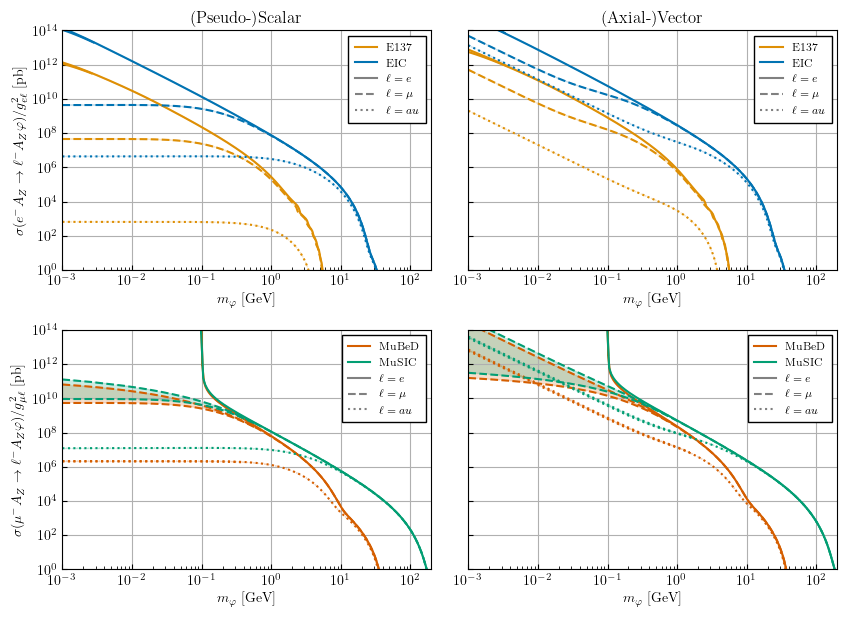

In [5]:
fig = plt.figure(figsize = (10, 7))
gs = GridSpec(2, 2, wspace = 0.1, hspace = 0.25)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

# electron beam experiments
ax1, ax2 = compare_particle_types([E137, EIC], ax1, ax2)

# muon beam experiments
ax3, ax4 = compare_particle_types([MuBeD, MuSIC], ax3, ax4)

ax3.set_title(None)
ax4.set_title(None)

plt.savefig('figures/chapter4/production_crossx.pdf', format = 'pdf', bbox_inches = 'tight')

### Comparing approximations:

To compare the approximate and exact cross-sections, we create a function ````plot_methods```` which generates plots of the cross-section computed via the exact, Weizsacker-Williams, and Improved Weizsacker-Williams approximations. We also create a function ````plot_method_errors```` which generates a plot of the relative error between the exact and approximat ereuslts. Finally, we wrap these into a function ````compare_methods```` which compares the approximations to the exact results and plots the relative error beneath.

In [6]:
# Helper function for computing relative error
def relative_error(exact, approx):
    return np.abs(approx - exact)/np.abs(exact)

def plot_methods(experiment,
                 lepton,
                 particle_type,
                 t_cut_off = 1.0,
                 masses = None,
                 color = None,
                 ax = None,
                 units = 'pb'):
    if not ax:
        ax == plt.gca() 

    if not color:
        color = color_dict[experiment]

    use_cached_masses = masses is None

    linestyles = ['solid', 'dashed', 'dotted']
    methods = ['exact', 'WW', 'IWW']
    for idx, (linestyle, method) in enumerate(zip(linestyles, methods)):
        params = (method, t_cut_off, lepton, particle_type)
        if use_cached_masses:
            masses = experiment.cached_masses(*params)
        plot_crossx(masses,
                    experiment,
                    params,
                    units = units,
                    ax = ax,
                    color = color,
                    linestyle = linestyle,
                    fill_alpha = 0.2*(method=='exact'))
        
def plot_method_errors(experiment,
                       lepton,
                       particle_type,
                       t_cut_off = 1.0,
                       masses = None,
                       ax = None,
                       color = None):
    if not ax:
        ax = plt.gca()
    
    if not color:
        color = color_dict[experiment]

    params = (t_cut_off, lepton, particle_type)
    
    use_cached_masses = masses is None
    if use_cached_masses:
        masses = experiment.cached_masses('exact', *params)
        
    params = (t_cut_off, lepton, particle_type)
    final_states = [FinalState('exact', *params, m) for m in masses]
    crossx_exact = np.array([experiment.cross_section(final_state) for final_state in final_states]).transpose()
    crossx_exact[1] = crossx_exact[0] + crossx_exact[1]

    for linestyle, method in zip(['dashed', 'dotted'], ['WW', 'IWW']):
        final_states = [FinalState(method, *params, m) for m in masses]
        crossx_approx = np.array([experiment.cross_section(final_state) for final_state in final_states]).transpose()
        crossx_approx[1] = crossx_approx[0] + crossx_approx[1]

        ax.plot(masses, relative_error(crossx_exact[0], crossx_approx[0]), color = color, linestyle = linestyle)
        ax.plot(masses, relative_error(crossx_exact[1], crossx_approx[1]), color = color, linestyle = linestyle)
    
def compare_methods(experiments,
                    lepton,
                    gs, #Input GridSpec rather than axes, so that the error plots can be generated
                    t_cut_off = 1.0,
                    masses = None,
                    ylim = (1e0,1e14),
                    error_ylim = (1e-6, 1e0),
                    xlim = (1e-3,1e2),
                    units = 'pb'):

    # UPPER LEFT: (Pseudo)-scalar
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title("$\\textrm{(Pseudo-)Scalar}$")

    # LOWER LEFT: Relative error for (pseudo)-scalar
    ax2 = fig.add_subplot(gs[2], sharex = ax1)
    
    params = (lepton, 'scalar', t_cut_off)
    for experiment in experiments:
        plot_methods(experiment, *params, masses = masses, ax = ax1)
        plot_method_errors(experiment, *params, masses = masses, ax = ax2)
        ax1.plot([1e16],
                 color = color_dict[experiment],
                 linestyle = 'solid',
                 label = TeX_dict[experiment])

    # UPPER RIGHT: (Axial)-vector
    ax3 = fig.add_subplot(gs[1])
    ax3.set_title("$\\textrm{(Axial-)Vector}$")

    # LOWER LEFT: Relative error for (axial)-vector
    ax4 = fig.add_subplot(gs[3], sharex = ax3)
    
    params = (lepton, 'vector', t_cut_off)        
    for experiment in experiments:
        plot_methods(experiment, *params, masses = masses, ax = ax3)
        plot_method_errors(experiment, *params, masses = masses, ax = ax4)
        ax3.plot([1e16],
                 color = color_dict[experiment],
                 linestyle = 'solid',
                 label = TeX_dict[experiment])

    # Format tick parameters    ax1.tick_params(which = 'both', direction = 'in', labelbottom = False)
    ax1.tick_params(which = 'both', direction = 'in', labelbottom = False)
    ax2.tick_params(which = 'both', direction = 'in')
    ax3.tick_params(which = 'both', direction = 'in', labelbottom = False, labelleft = False)
    ax4.tick_params(which = 'both', direction = 'in', labelleft = False)

    # Set y-labels (only for left-most plots)
    li = experiment.lepton
    li = li if li == 'e' else f'\\{li}'
    lf = lepton if lepton == 'e' else f'\\{lepton}'

    ax1.set_ylabel(f'$\\sigma({li}^- A_Z \\rightarrow {lf}^- A_Z \\varphi)/g_{{{li}{lf}}}^2~[{{\\rm {units}}}]$')
    ax2.set_ylabel('$\\textrm{rel. error}$')

    # Formatting that's identical for each axis
    axes = [ax1, ax2, ax3, ax4]
    for idx, ax in enumerate(axes):
        ax.grid()
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        if idx%2 == 0:
            if ylim:
                ax.set_ylim(*ylim)        
                
            # Legend for methods
            linestyles = ['solid', 'dashed', 'dotted']
            methods = ['exact','WW', 'IWW']
            for linestyle, method in zip(linestyles, methods):
                ax.plot([1e16],
                        color = 'grey',
                        linestyle = linestyle,
                        label = f'$\\textrm{{{method}}}$')

        
            ax.legend(fancybox = False,
                      facecolor = 'white',
                      edgecolor = 'black',
                      framealpha = 1,
                      loc = 'upper right',
                      fontsize = 8,
                      borderpad = 0.6)
            
        if idx%2 == 1:
            if error_ylim:
                ax.set_ylim(*error_ylim)
            if xlim:
                ax.set_xlim(*xlim)
            ax.set_xlabel('$m_\\varphi~[\\textrm{GeV}]$')            
            
    return axes

We can compare the approximations and exact results for the on-diagonal production $\ell^- A_Z \rightarrow \ell^- A_Z \varphi$:

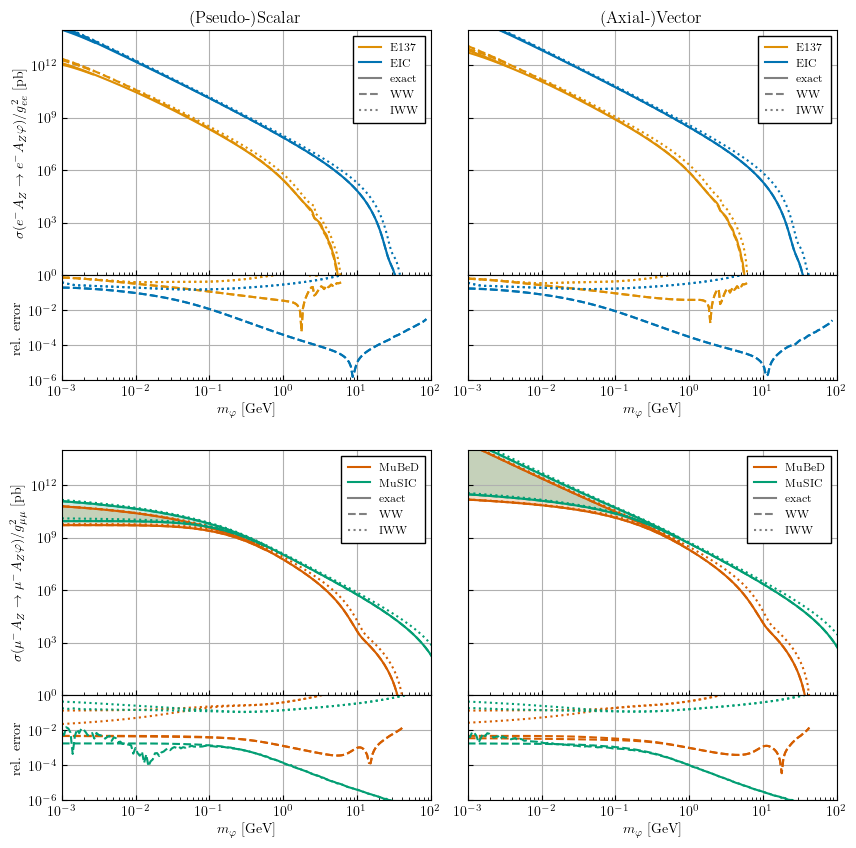

In [7]:
fig = plt.figure(figsize=(10, 10))

gs =  GridSpec(2, 1, height_ratios=[1, 1], hspace=0.2)

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[0], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax1, ax2, ax3, ax4 = compare_methods([E137, EIC], 'e', sub_gs)
ax1.set_yticks([1e3, 1e6, 1e9, 1e12])
ax3.set_yticks([1e3, 1e6, 1e9, 1e12])

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[1], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax5, ax6, ax7, ax8 = compare_methods([MuBeD, MuSIC], 'mu', sub_gs)
ax5.set_yticks([1e3, 1e6, 1e9, 1e12])
ax7.set_yticks([1e3, 1e6, 1e9, 1e12])
ax5.set_title(None)
ax7.set_title(None)

plt.savefig('figures/chapter4/crossx_approximations_diagonal.pdf', bbox_inches = 'tight')

And we can also compare the approximations and exact results for the off-diagonal production of a $\tau$ via $\ell^- A_Z \rightarrow \tau^- A_Z \varphi$:

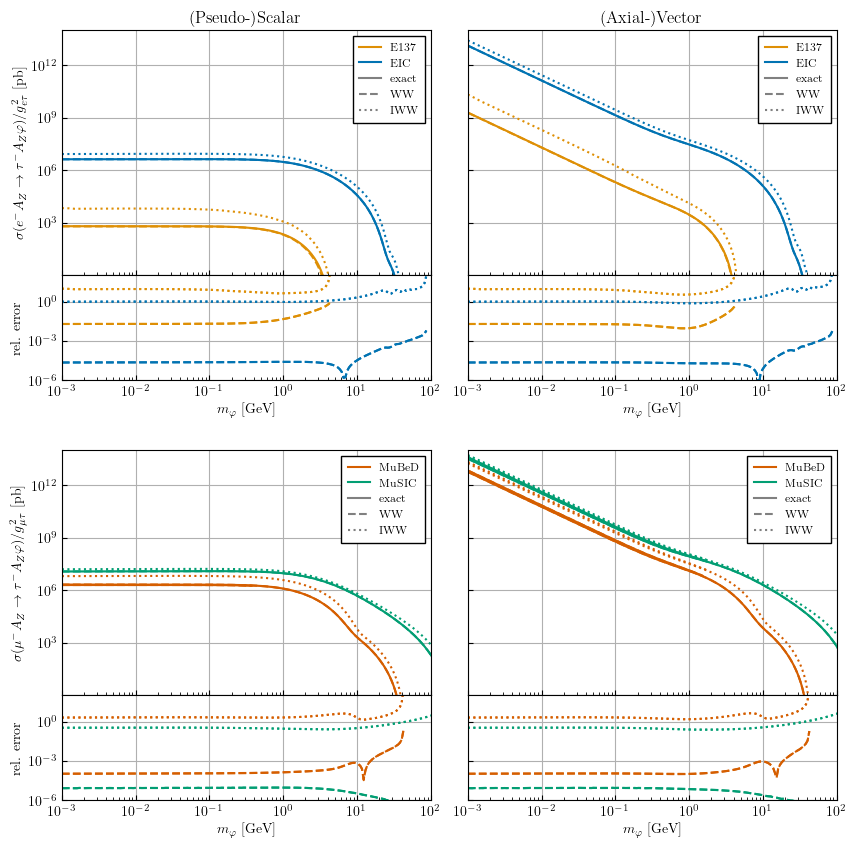

In [8]:
fig = plt.figure(figsize=(10, 10))

gs =  GridSpec(2, 1, height_ratios=[1, 1], hspace=0.2)

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[0], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax1, ax2, ax3, ax4 = compare_methods([E137, EIC], 'tau', sub_gs)
ax1.set_yticks([1e3, 1e6, 1e9, 1e12])
ax3.set_yticks([1e3, 1e6, 1e9, 1e12])

ax2.set_ylim(1e-6, 1e2)
ax4.set_ylim(1e-6, 1e2)

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[1], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax5, ax6, ax7, ax8 = compare_methods([MuBeD, MuSIC], 'tau', sub_gs)
ax5.set_yticks([1e3, 1e6, 1e9, 1e12])
ax7.set_yticks([1e3, 1e6, 1e9, 1e12])

ax6.set_ylim(1e-6, 1e2)
ax8.set_ylim(1e-6, 1e2)

ax5.set_title(None)
ax7.set_title(None)

plt.savefig('figures/chapter4/crossx_approximations_tau.pdf', bbox_inches = 'tight')